In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import optuna

from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve, auc, make_scorer, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier

# setar pandas para mostrar todas as colunas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
treino = pd.read_excel('treino.xlsx')
treino.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,Class
0,1,-0.30,0.53,0.59,0.09,0.02,0.02,0.05,0.18,-0.04,-0.20,-0.51,-0.17,-0.01,0.08,0.78,0.05,-0.18,0.20,0.19,0.05,0.08,0
1,2,0.53,-0.09,0.34,0.57,-0.32,0.20,-0.30,0.21,0.29,-0.01,0.73,0.18,-0.93,0.25,0.23,-0.12,0.05,-0.09,-0.32,-0.13,0.05,0
2,3,0.61,-0.02,-0.04,-0.02,-0.14,-0.14,0.09,-0.09,-0.59,0.28,-0.30,0.35,0.68,-0.08,-0.04,-0.92,0.02,0.14,-0.37,-0.08,-0.27,0
3,4,-0.35,0.65,0.47,-0.17,0.13,-0.22,0.30,0.08,-0.22,-0.11,-0.52,0.10,0.56,0.00,0.41,0.24,-0.36,-0.09,0.21,0.11,-0.14,0
4,5,0.24,-0.69,0.53,0.43,-0.37,0.80,-0.33,0.23,0.78,-0.42,-0.15,0.82,0.56,-0.48,0.04,-0.62,0.55,-0.96,-0.38,0.24,0.04,0


* Não sabemos o que representam cada uma das variáveis, mas podemos explorá-las mesmo assim
* A ideia é analisar como se distribuem os valores para casos fraudulentos e não fraudulentos

In [3]:
treino.drop('id', axis=1, inplace=True)
fraud = treino[treino['Class'] == 1]
non_fraud = treino[treino['Class'] == 0]

* Existem várias maneiras de se fazer essa exploração
* Uma delas é visualizando cada atributo em um histograma

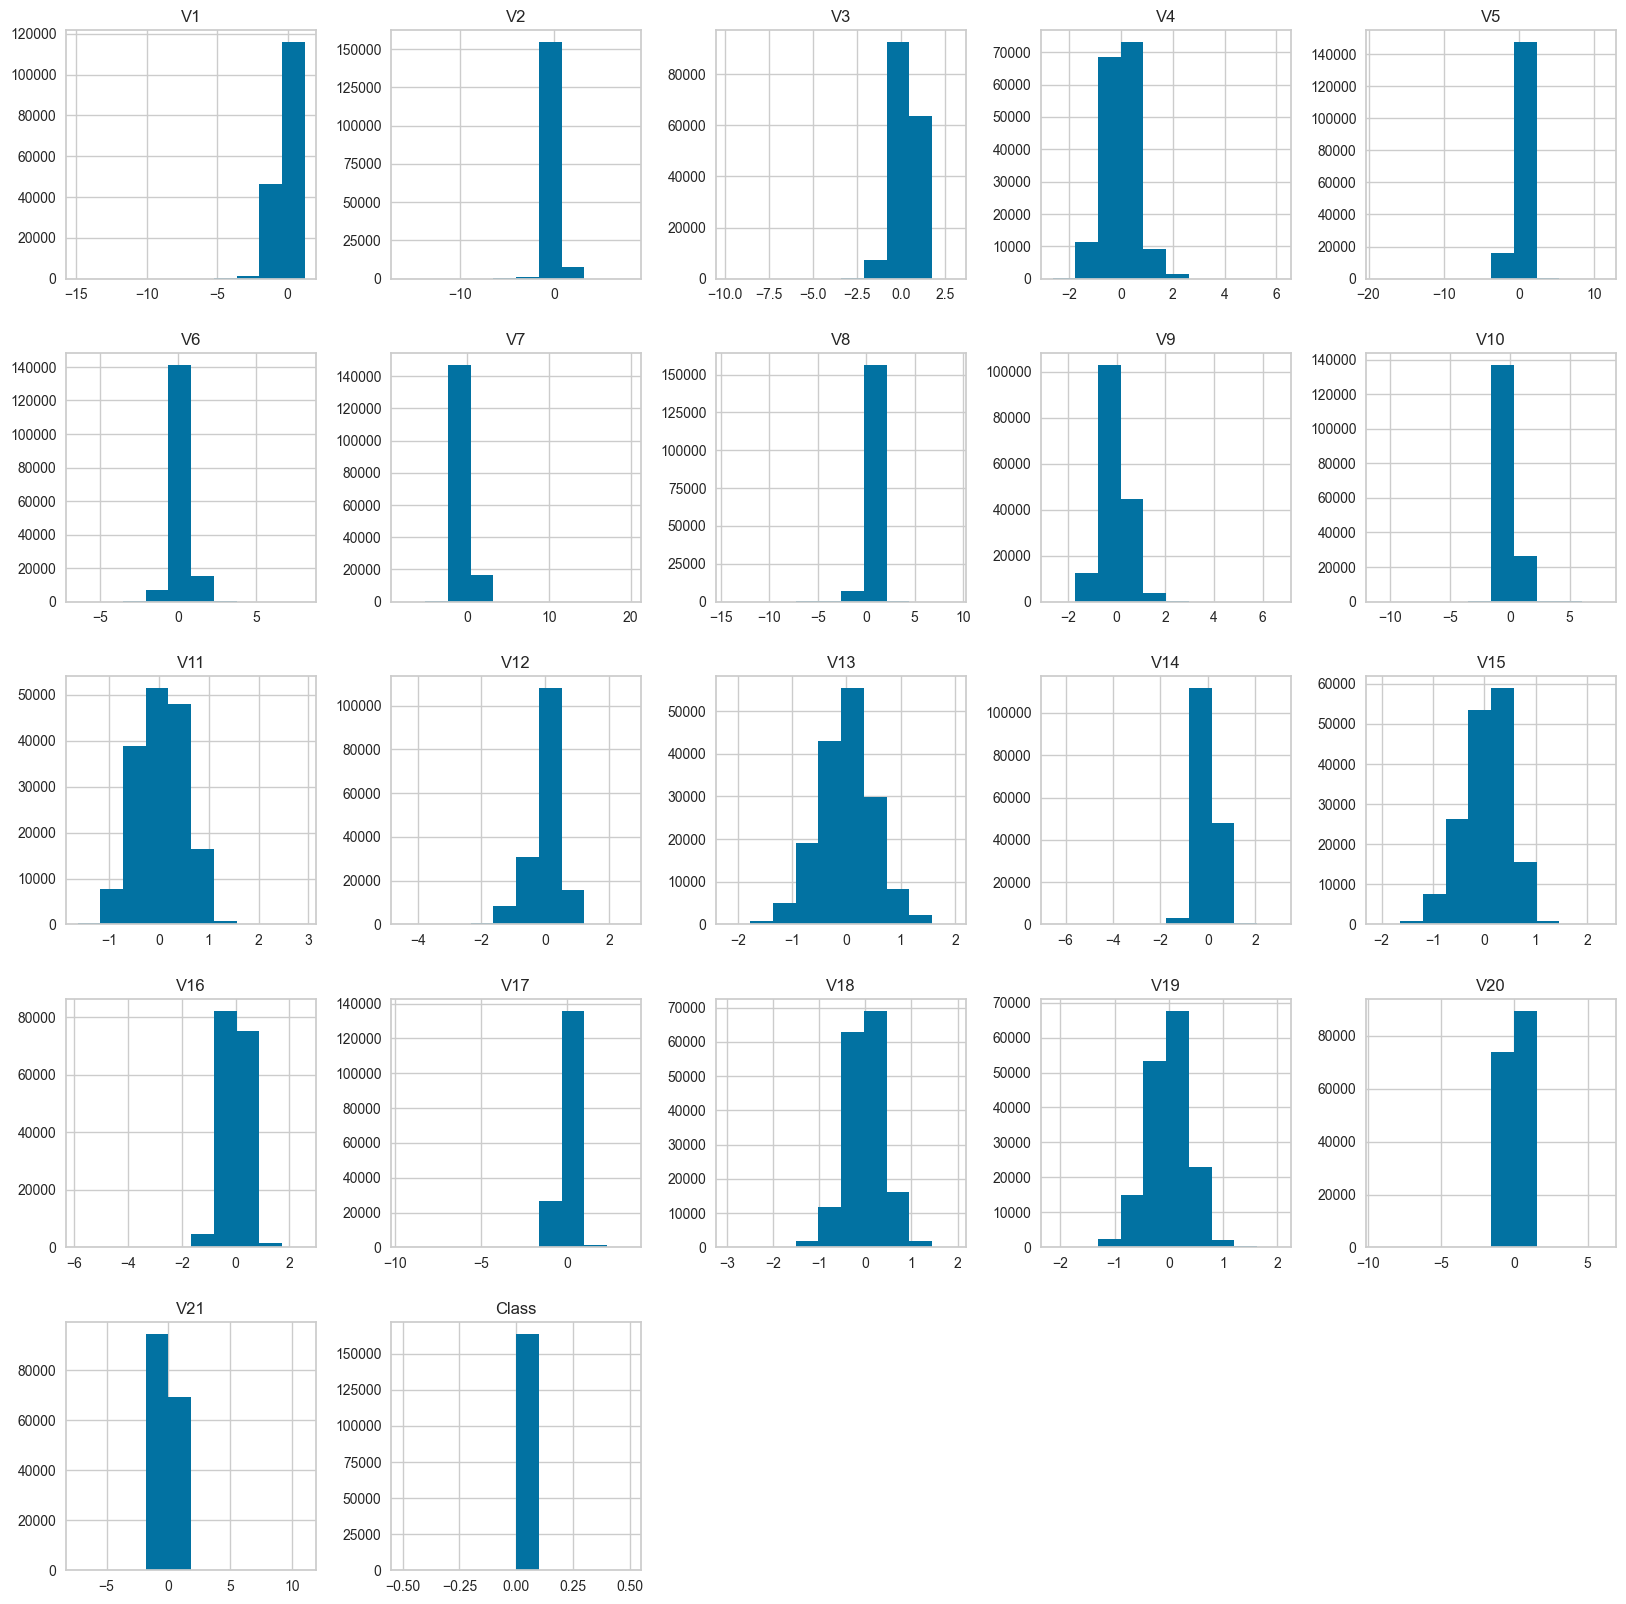

In [10]:
non_fraud.hist(figsize=(20, 20))
plt.show()

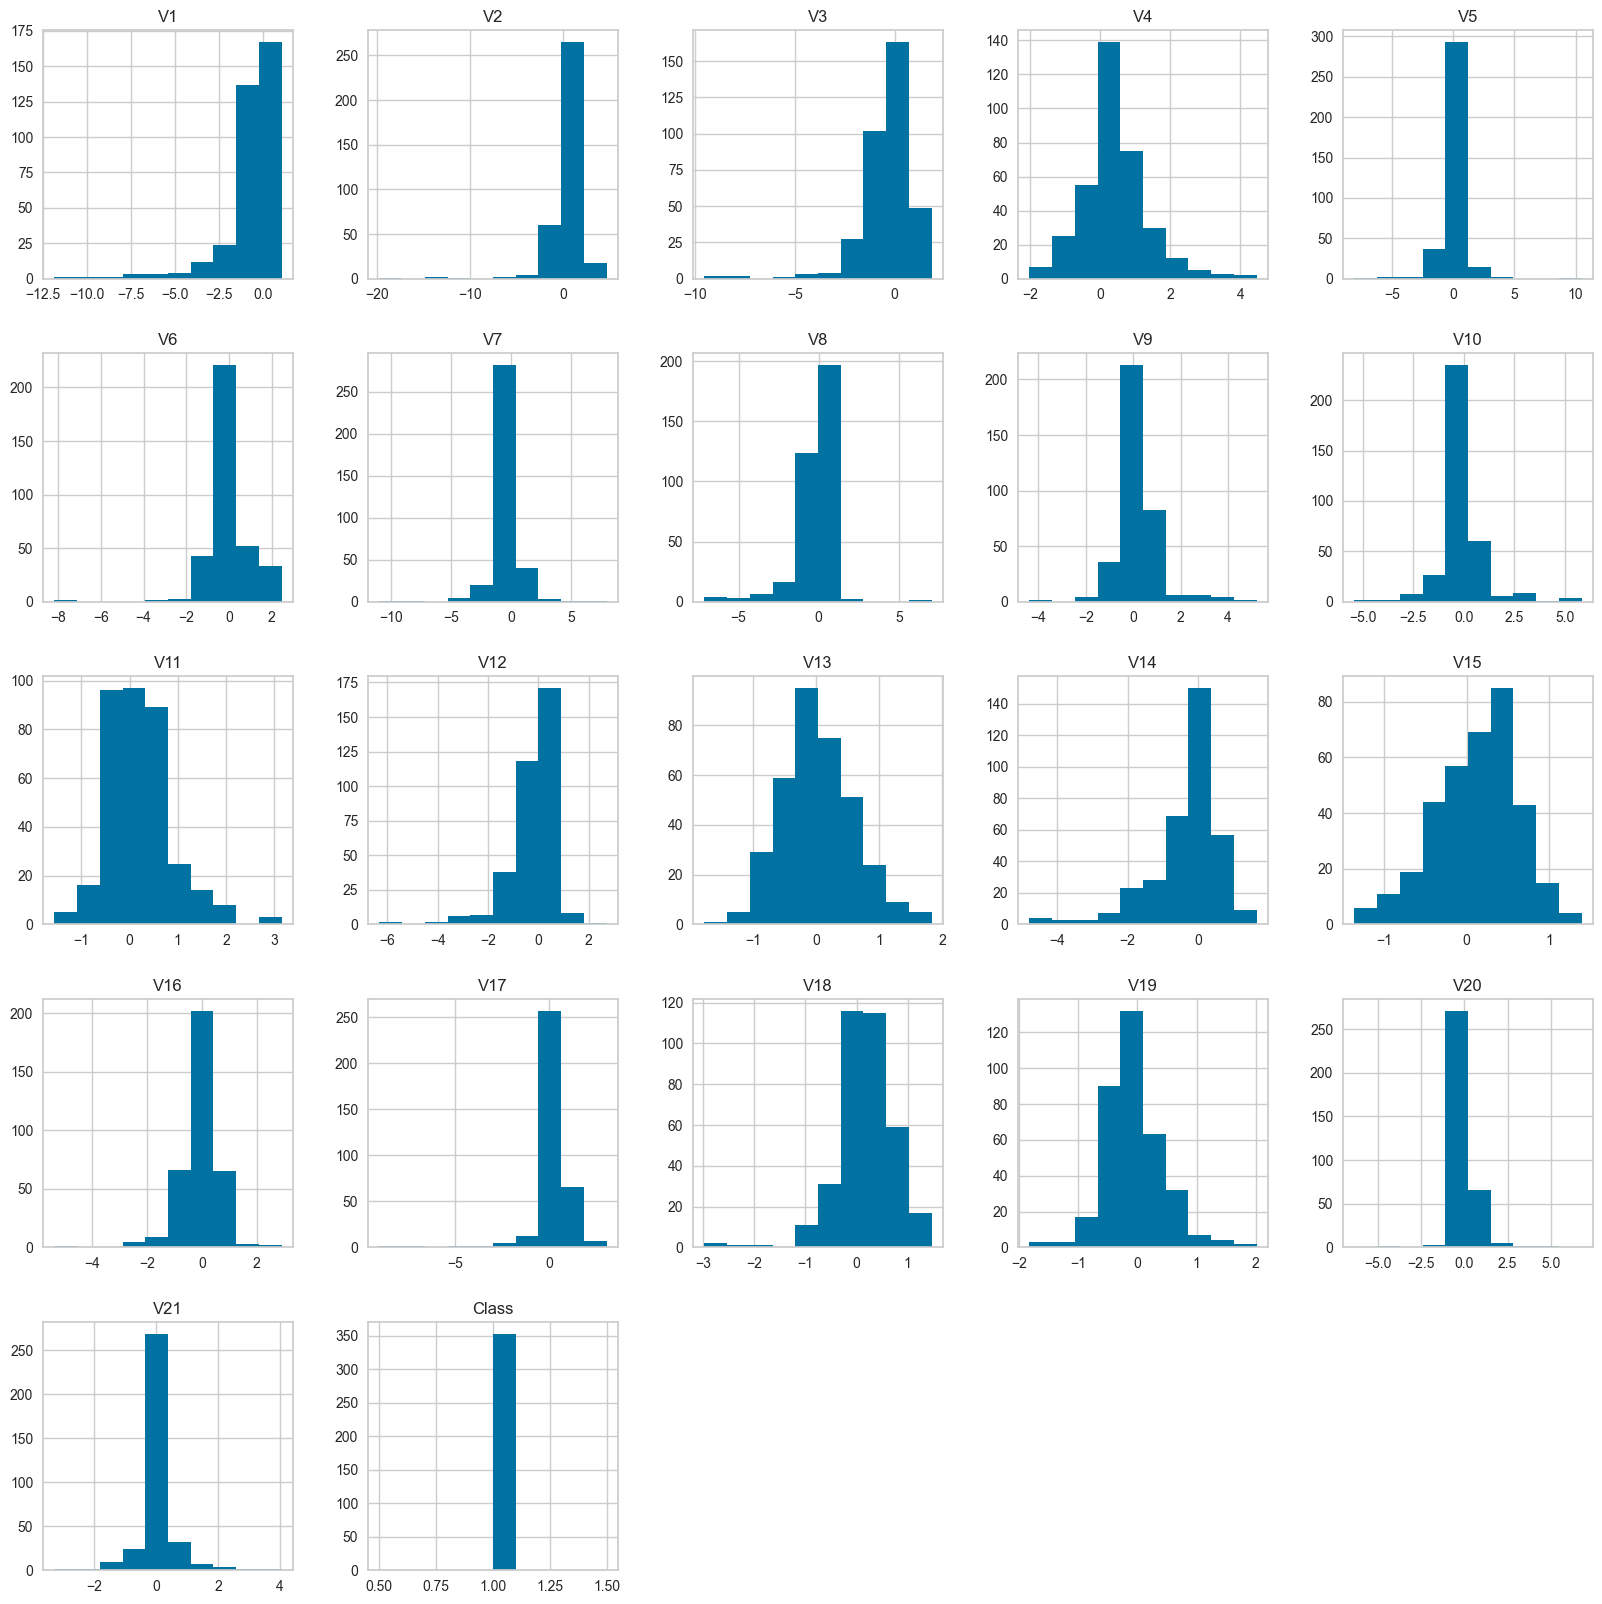

In [11]:
fraud.hist(figsize=(20, 20))
plt.show()

* Plotar vários histogramas em um mesmo gráfico pode ser uma boa ideia, mas a depender do tamanho do dataset, pode ser difícil de visualizar
* Podemos juntar todos os histogramas em um único gráfico, mas isso também vem com suas próprias dificuldades

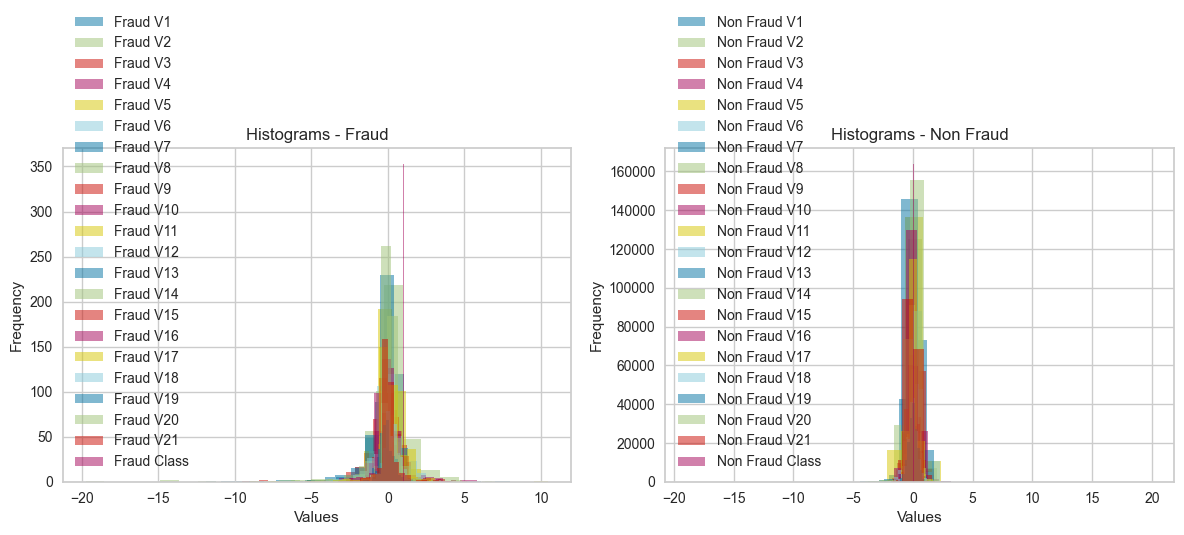

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for i, col in enumerate(fraud.columns):
    axs[0].hist(fraud[col], alpha=0.5, label=f'Fraud {col}', bins=20)

for i, col in enumerate(non_fraud.columns):
    axs[1].hist(non_fraud[col], alpha=0.5, label=f'Non Fraud {col}', bins=20)

axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histograms - Fraud')
axs[0].legend()

axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histograms - Non Fraud')
axs[1].legend()

plt.tight_layout()
plt.show()

* O ideal mesmo é fazer esse processo com Plotly, pois nos permite selecionar quais atributos queremos visualizar e também nos permite interagir com o gráfico
* O downside: a imagem é bem mais pesada

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Non Fraud'))

for col in non_fraud.columns:
    fig.add_trace(go.Histogram(x=non_fraud[col], name=f'Non Fraud {col}', opacity=0.5),
                  row=1, col=1)

for col in fraud.columns:
    fig.add_trace(go.Histogram(x=fraud[col], name=f'Fraud {col}', opacity=0.5),
                  row=1, col=2)

fig.update_layout(
    title_text='Comparação das distribuições',
    xaxis=dict(title='Values'),
    yaxis=dict(title='Frequency'),
)

fig.show()

* É um pouco difícil tirar conclusões sem conhecer os dados ou apenas olhando
* Mas uma comparação superficial nos mostra que algumas variáveis têm comportamentos diferentes para casos fraudulentos e não fraudulentos
* No geral, a impressão é que a de que os casos fraudulentos possuem uma variância maior em relação à média
* Além disso, em alguns gráficos é possível notar que as duas ocasiões possuem um certo _skew_ para direções opostas

In [4]:
for i in non_fraud.iloc[:, :-1].columns:
    print(f'A média da variável {i} para classe 0 é:', non_fraud[i].mean())
    print(f'A média da variável {i} para classe 1 é:', fraud[i].mean())
    print('------------------')


A média da variável V1 para classe 0 é: 0.02201555641459468
A média da variável V1 para classe 1 é: -0.5359671590227408
------------------
A média da variável V2 para classe 0 é: 0.028706660685950333
A média da variável V2 para classe 1 é: 0.18196777385148613
------------------
A média da variável V3 para classe 0 é: 0.27634548289919675
A média da variável V3 para classe 1 é: -0.40068121648727867
------------------
A média da variável V4 para classe 0 é: 0.023072573449444612
A média da variável V4 para classe 1 é: 0.4094139174408404
------------------
A média da variável V5 para classe 0 é: -0.06338677570656193
A média da variável V5 para classe 1 é: 0.043045029064120645
------------------
A média da variável V6 para classe 0 é: 0.08744831826313273
A média da variável V6 para classe 1 é: -0.002571055339381892
------------------
A média da variável V7 para classe 0 é: -0.0608078456967143
A média da variável V7 para classe 1 é: -0.24268224483751424
------------------
A média da variável 

In [5]:
for i in non_fraud.iloc[:, :-1].columns:
    print(f'A média da variável {i} para classe 0 é:', non_fraud[i].std())
    print(f'A média da variável {i} para classe 1 é:', fraud[i].std())
    print('------------------')


A média da variável V1 para classe 0 é: 0.7061398682121908
A média da variável V1 para classe 1 é: 1.6540917581707089
------------------
A média da variável V2 para classe 0 é: 0.5855333114721416
A média da variável V2 para classe 1 é: 2.028482136283019
------------------
A média da variável V3 para classe 0 é: 0.5763439986549131
A média da variável V3 para classe 1 é: 1.3683023907676222
------------------
A média da variável V4 para classe 0 é: 0.6307336912141535
A média da variável V4 para classe 1 é: 0.9082158935419805
------------------
A média da variável V5 para classe 0 é: 0.545485557805565
A média da variável V5 para classe 1 é: 1.104120926557991
------------------
A média da variável V6 para classe 0 é: 0.6150173388926917
A média da variável V6 para classe 1 é: 0.924701431597791
------------------
A média da variável V7 para classe 0 é: 0.41043867136781026
A média da variável V7 para classe 1 é: 1.2348464426568646
------------------
A média da variável V8 para classe 0 é: 0.36

### Separar em treino e teste

* Separação dos dados em treino e teste
* Parâmetro super importante neste caso, é o _stratify_
* Isso porque como o dataset é desbalanceado, é altamente provável que só haja elementos de uma única classe no treino
* O _stratify_ permite que a proporção de elementos de cada classe seja mantida no treino e no teste

In [18]:
X = treino.iloc[:, :-1]  # Features
y = treino['Class']  # Target 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Regressão logística

* Aqui na Regressão Logística, também setamos um parâmetro importante, a _class_weight_
* Assim, o modelo ajusta proporcionalmente os pesos de cada classe de acordo com a sua frequência

In [21]:
# Treinar e avaliar um modelo de regressão logística
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
y_pred_val_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_val_logreg)

print("Regressão Logística - Resultados de Validação:")
print("AUC Score:", roc_auc_score(y_test, y_pred_val_logreg))
print("Accuracy:", accuracy_logreg)

Regressão Logística - Resultados de Validação:
AUC Score: 0.7118204405834568
Accuracy: 0.8175480256948884


* Em casos desbalanceados como esse, não podemos cair no erro de apenas considerara a acurácia do modelo
* É essencial visualizar as classes em que houveram erros
* Para isso, podemos usar a matriz de confusão
* Aqui nos interessa, principalmente, os quadrante 2 e 3, que contém os falsos positivos e os falsos negativos, respectivamente

In [22]:
confusion_matrix(y_test, y_pred_val_logreg)

array([[26811,  5965],
       [   28,    43]], dtype=int64)

* Para tentar melhorar nossa performance, vamos aplicar o método de validação cruzada
* Esse método consiste em dividir o dataset em k partes e treinar o modelo k vezes, cada vez usando uma parte diferente como teste
* Isso evita que o modelo fique enviesado demais para um conjunto de dados específico
* Como métrica para essas validações, estamos utilizando o AUC da curva ROC, que essencialmente mede a taxa de verdadeiros positivos em função de falsos positivos
e quanto mais próximo de 1, melhor

In [24]:
scorer = make_scorer(roc_auc_score)
cv_results = cross_validate(logreg, X_train, y_train, cv=10, scoring=scorer, return_estimator=True)
cv_results['test_score']  # Resultados do AUC em cada fold

array([0.7469968 , 0.6638891 , 0.82077251, 0.70309582, 0.64366078,
       0.76293996, 0.78224638, 0.69414297, 0.71241964, 0.69399041])

In [28]:
gtest_score = []
for i in range(len(cv_results['estimator'])):
    gtest_score.append(cv_results['estimator'][i].score(X_test, y_test))  # Testa cada um dos modelos da validação cruzada no conjunto de teste
gtest_score

[0.817152251347155,
 0.8301823606417633,
 0.8039090327883825,
 0.8221755411453101,
 0.8180046884038116,
 0.8122811824519743,
 0.8114896337565074,
 0.8176089140560782,
 0.8169391420829908,
 0.8158735957621701]

In [29]:
result = []
for i in range(len(cv_results['estimator'])):
    result.append(cv_results['estimator'][i].predict(X_test))

In [35]:
y_pred = result[1]  
print('AUC: ', roc_auc_score(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

AUC:  0.7251782908827139
Accuracy:  0.8301823606417633
Confusion Matrix: 
 [[27225  5551]
 [   27    44]]


* Houve uma melhora pequena, de mais ou menos 1%, mas que representou uma diminuição de cerca de 400 casos classificados como fraude erroneamente

* Buscando sempre melhorar nossos modelos, uma coisa que podemos fazer é selecionar melhor as variáveis passadas
* Muitas vezes algumas não contribuem tanto para a classificação e podem ser descartadas
* O cálculo de _feature_importance_ é algo que pode ser analisado em conjunto com os gráficos de distribuições das variáveis calculados anteriormente

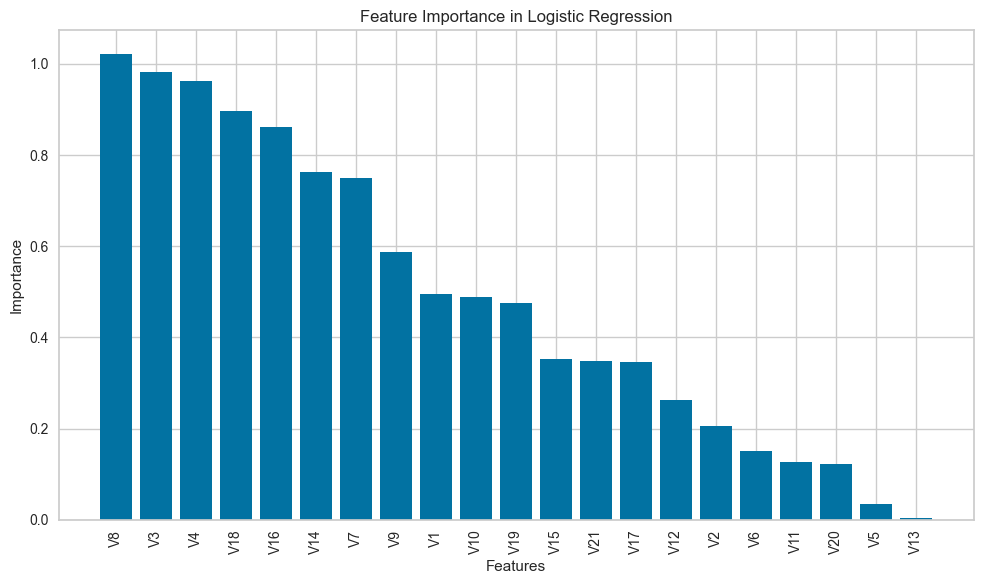

In [32]:
feature_importance = np.abs(logreg.coef_[0])
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]

feature_names = X.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), sorted_importance)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Logistic Regression")
plt.tight_layout()
plt.show()

# Só para mostrar, mas nesse arquivo eu não removi as colunas

In [37]:
def punir_os_infieis(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fn_penalty = 30
    fp_penalty = 50
    tn_bonus = -5
    tp_bonus = -3

    loss = fn_penalty * fn + fp_penalty * fp + tn_bonus * tn + tp_bonus * tp
    return -loss

In [38]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
params = {'C': [0.01, 0.1, 1],
          'solver': ['liblinear', 'sag', 'saga'],
          'max_iter':[100,200],
          'penalty': ['l1', 'l2']}

custom_scorer = make_scorer(punir_os_infieis)
model_cv = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'), param_grid=params, scoring=custom_scorer, cv=folds, verbose=1, return_train_score=True)
cv_model = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [39]:
print('Best Params: ', cv_model.best_params_)
print('Best Score: ', cv_model.best_score_)

y_pred = cv_model.predict(X_test)
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('AUC', roc_auc_score(y_test, y_pred))

Best Params:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  -131811.4
Precision 0.0071906354515050164
Recall 0.6056338028169014
AUC 0.712247582394538


In [40]:
confusion_matrix(y_test, y_pred)

array([[26839,  5937],
       [   28,    43]], dtype=int64)